# Kalman Filter
## Zein Alabedeen Barhoum

# Task

**System description:**

Consider a model of horizontal movement of a surface vessel. Let us assume that the thrust force compensates for the longitudinal hydrodynamic resistance and the motion occurs at a constant speed $V_0 = V_x = const$.

![model](model.png)

The motion dynamics can be described by the following system of equations:

$$
\left[
    \begin{array}{c}
        \dot{\varphi} \\
        \dot{\omega} \\
        \dot{V}
    \end{array}
\right] = 

\left[
    \begin{array}{ccc}
        0 & 1 & 0 \\
        0 & a_{22} & a_{23}/V_0 \\
        0 & a_{32}V_0 & a_{33}
    \end{array}
\right] 
\left[
    \begin{array}{c}
        \varphi \\
        \omega \\
        V
    \end{array}
\right] +

\left[
    \begin{array}{c}
        0 \\
        b_{21} \\
        b_{31}
    \end{array}
\right] \delta
$$

where $\phi$ is a vessel's heading direction, $\omega$ is a vessel's angular velocity, $V_z$ is a vessel's transverse speed, $\delta$ is vessel's rudder angle,
$a_{22}=-328$,  $a_{23}=2060$, $a_{32}=0.58$, $a_{33}=-5150$, $b_{21}=1$, $b_{31}=18$  are constants.

The heading direction of the vessel is available for measurement with an error with a normal distribution and zero mean. The deviation of the model from the vessel is also described by a normal distribution with zero mean.

**Tasks:**

1. Define vessel parameters.
2. Define model variances (heading direction, angular velocity and transverse velocity) and sensor variance.
3. Model the vessel's trajectory for 4 different rudder angles.
4. Build a Kalman filter to assess the state of the vessel.
5. Plot graphs of measurement and estimates of state variables.
6. Get formulas for determining the global coordinates of the vessel from state variables.
7. Plot the vessel's trajectory, its measurement and estimates.

# Solution

In [5]:
import numpy as np
import matplotlib.pyplot as plt

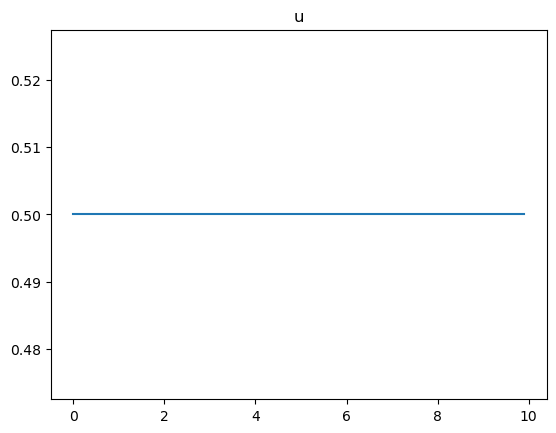

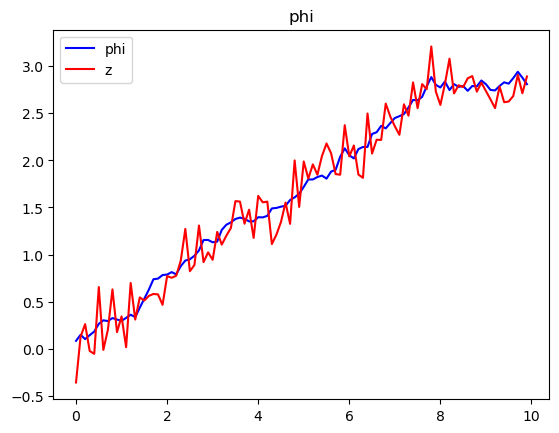

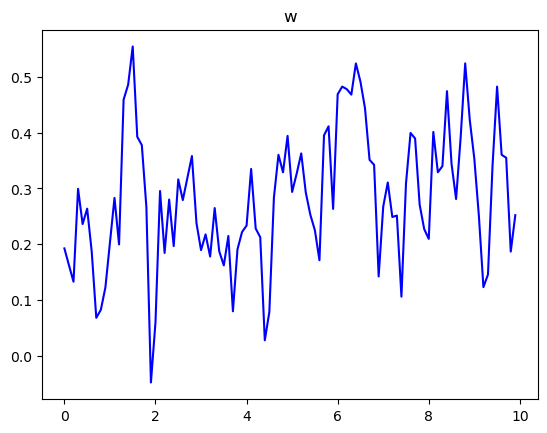

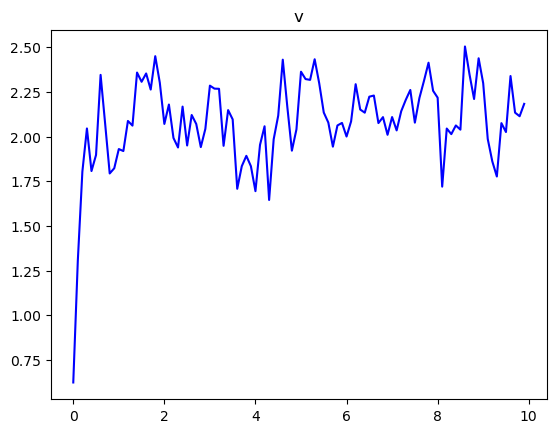

In [6]:
duration = 10
dt = 0.1

V0 = 10
a22 = -3
a23 = 2
a32 = 0.58
a33 = -5
b21 = 1
b31 = 18



A = np.array([[0, 1, 0], [0, a22, a23/V0], [0, a32*V0, a33]])*dt + np.eye(3)
B = np.array([[0], [b21], [b31]])*dt
C = np.array([[1, 0, 0]])

# std_ph = 0.5
# std_w = 0.7
# std_v = 1.3
# std_z = 0.8

std_ph = 0.05
std_w = 0.1
std_v = 0.15

std_z = 0.2

Ex = [[std_ph**2, std_ph*std_w, std_ph*std_v], 
      [std_w*std_ph, std_w**2, std_w*std_v], 
      [std_v*std_ph, std_v*std_w, std_v**2]]
Ez = std_z**2

ph = []
w = []
v = []
z = []
t = []

x = np.array([[0], [0], [0]])

u_vars = [np.pi/6, -np.pi/3, np.pi/3, 0]
u_vars =[0.5, 0.5, 0.5, 0.5]
us = []
for i in np.arange(0, duration, dt):
    u = u_vars[int(i//2.5)]
    us.append(u)
    t.append(i)
    x_noise = np.array([[np.random.normal(0, std_ph),
               np.random.normal(0, std_w),
               np.random.normal(0, std_v),
               ]]).T
    x = np.matmul(A, x) + B*u+ x_noise
    meas_noise = np.random.normal(0, std_z)
    y = float(np.matmul(C, x)) + meas_noise
    ph.append(x[0][0])
    w.append(x[1][0])
    v.append(x[2][0])
    z.append(y)


plt.title('u')
plt.plot(t, us)
plt.show()

plt.plot(t, ph, c='b')
plt.title('phi')
plt.plot(t, z, c='r')
plt.legend(['phi', 'z'])
plt.show()

plt.plot(t, w, c='b')
plt.title('w')
plt.show()

plt.plot(t, v, c='b')
plt.title('v')
plt.show()

In [7]:
ph_est = []
w_est = []
v_est = []
x = np.array([[0], [0], [0]])
Sigma = Ex.copy() # initial covariance


for i in range(len(t)):
    u = us[i]
    x_pred = np.matmul(A, x) + B*u

    Sigma_pred = np.matmul(np.matmul(A, Sigma), A.T) + Ex
   
    temp = np.matmul(C, Sigma_pred)
    temp = np.matmul(temp, C.T)
    temp = temp + Ez
    temp = np.linalg.inv( temp)
    temp = np.matmul(C.T, temp)
        
    K = np.matmul(Sigma_pred, temp)
    
    x = x_pred + K* ( z[i] - np.matmul(A, x_pred))
    ph_est.append(x[0][0])
    w_est.append(x[1][0])
    v_est.append(x[2][0])
    
    temp = np.eye(3) - np.matmul(K, C)
    Sigma = np.matmul(temp, Sigma_pred)

In [8]:
K

array([[0.28392413],
       [0.23142059],
       [0.41873272]])

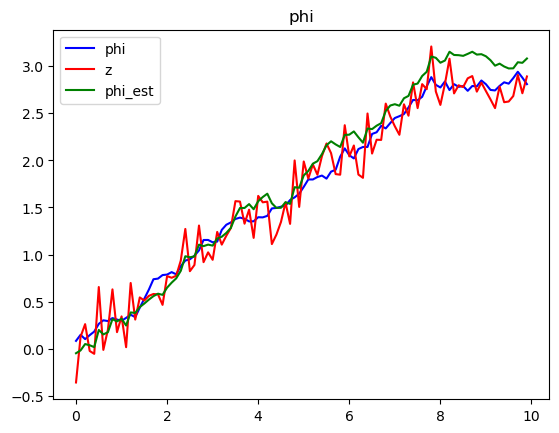

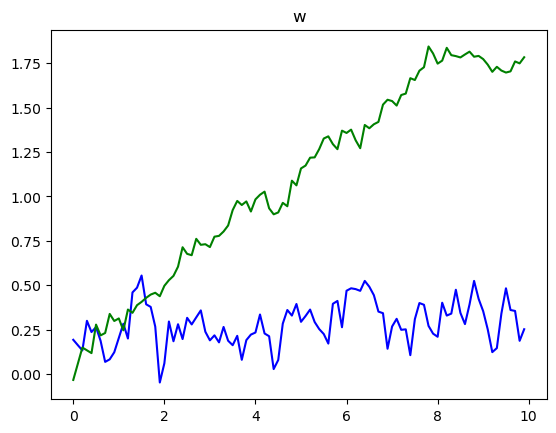

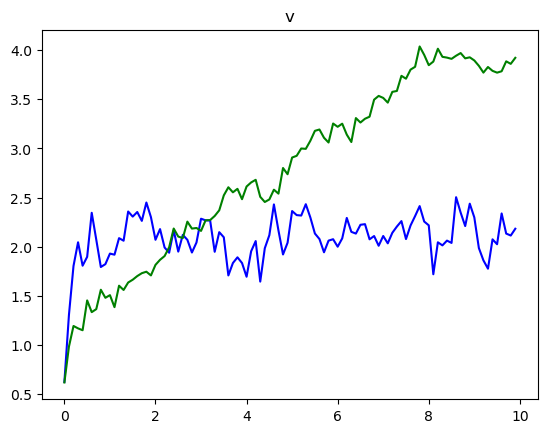

In [9]:
plt.plot(t, ph, c='b')
plt.plot(t, z, c='r')
plt.plot(t, ph_est, c='g')

plt.title('phi')

plt.legend(['phi', 'z', 'phi_est'])
plt.show()

plt.plot(t, w, c='b')
plt.plot(t, w_est, c='g')
plt.title('w')
plt.show()

plt.plot(t, v, c='b')
plt.plot(t, v_est, c='g')
plt.title('v')
plt.show()

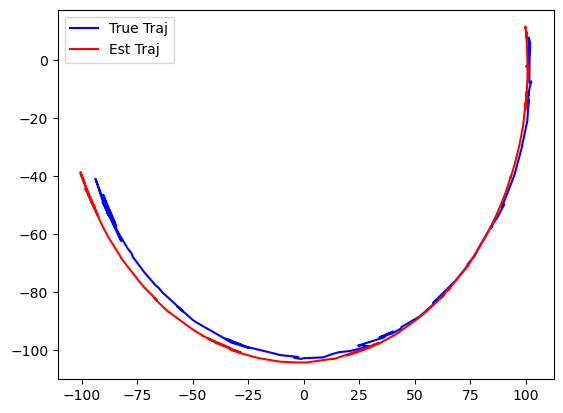

In [10]:
dx_traj = V0*np.cos(ph)+v*np.sin(ph)
dz_traj = -V0*np.sin(ph)+v*np.cos(ph)

dx_traj_est = V0*np.cos(ph_est)+v_est*np.sin(ph_est)
dz_traj_est = -V0*np.sin(ph_est)+v_est*np.cos(ph_est)

x_traj_est, z_traj_est, x_traj, z_traj = 0, 0, 0, 0
for i in range(len(t)):
    x_traj += dx_traj*dt
    z_traj += dz_traj*dt
    
    x_traj_est += dx_traj_est*dt
    z_traj_est += dz_traj_est*dt

plt.plot(x_traj, z_traj, 'b')
plt.plot(x_traj_est, z_traj_est, 'r')
plt.legend(['True Traj', 'Est Traj'])
plt.show()